## Table of content
1. Metadata
2. Data cleaning & feature engineering
3. Inspection
4. RoBERTa Pretrained Model
5. Modelling 
6. Assessing & Finetuning

In [1]:
# importing libraries
import numpy as np
import pandas as pd


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('grayscale')

# Roberta Pretrained Model
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

from sklearn import tree, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC



from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score




## Metadata
- **reviewer_id**: Unique identifier for each reviewer (anonymized)
- **store_name**: Name of the McDonald's store
- **category**: Category or type of the store
- **store_address**: Address of the store
- **latitude**: Latitude coordinate of the store's location
- **longitude**: Longitude coordinate of the store's location
- **rating_count**: Number of ratings/reviews for the store
- **review_time**: Timestamp of the review
- **review**: Textual content of the review
- **rating**: Rating provided by the reviewer

In [2]:
#Loading the dataset (encoded in latin-1)
df = pd.read_csv('McDonald_s_Reviews.csv', encoding = 'latin-1')
print("Number of datapoints:", len(df))
df.head()

Number of datapoints: 33396


,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


#### For more information about the dataset, please visit: 

https://www.kaggle.com/datasets/nelgiriyewithana/mcdonalds-store-reviews/data

## Data Cleaning

#### In this section:
- Data cleaning
- Feature Engineering

In [3]:
# information on features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewer_id    33396 non-null  int64  
 1   store_name     33396 non-null  object 
 2   category       33396 non-null  object 
 3   store_address  33396 non-null  object 
 4   latitude       32736 non-null  float64
 5   longitude      32736 non-null  float64
 6   rating_count   33396 non-null  object 
 7   review_time    33396 non-null  object 
 8   review         33396 non-null  object 
 9   rating         33396 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.5+ MB


There are some missing values in column latitude & longtitude, but these pieces of data are not too important since we already have the addresses of the stores, so I will not be removing the rows with such missing values. 

Column store_name and category both only have 1 unique value, so I will remove these columns.

I will also remove column reviewer_id, rating_count, and review_time since this information is irrelevant

In [4]:
df.drop(['category', 'store_name', 'rating_count', 'review_time'], axis=1, inplace=True)
df.head()

,reviewer_id,store_address,latitude,longitude,review,rating
0,1,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,Why does it look like someone spit on my food?...,1 star
1,2,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,Made a mobile order got to the speaker and che...,1 star
3,4,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"I repeat my order 3 times in the drive thru, a...",1 star


Now, I will be exploring the unique values in some columns to get a clear idea of the data.

In [5]:
print("Total categories in the feature store_address:\n", df["store_address"].value_counts(), "\n")
print("Total categories in the feature rating:\n", df["rating"].value_counts(), "\n")

Total categories in the feature store_address:
 store_address
9814 International Dr, Orlando, FL 32819, United States                       1890
5725 W Irlo Bronson Memorial Hwy, Kissimmee, FL 34746, United States          1720
10901 Riverside Dr, North Hollywood, CA 91602, United States                  1710
1415 E State Rd, Fern Park, FL 32730, United States                           1700
632 S R L Thornton Freeway Service Rd, Dallas, TX 75203, United States        1650
3501 Biscayne Blvd, Miami, FL 33137, United States                            1570
621 Broadway, Newark, NJ 07104, United States                                 1290
1100 N US Hwy 377, Roanoke, TX 76262, United States                           1168
72-69 Kissena Blvd, Queens, NY 11367, United States                           1140
429 7th Ave, New York, NY 10001, United States                                1140
724 Broadway, New York, NY 10003, United States                               1140
By Mandalay Bay, 3999 S L

In the above cell, I notice that in column store_address, there is a value with a typo: 

2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ 

After doing research, I found out the right address for this McDonald's store is: 

2476 Kalakaua Ave, Honolulu, HI 96815, United States

I will replace the typo in the dataframe with the correct address

In [6]:
df['store_address'] = df['store_address'].replace("2476 Kalï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½", "2476 Kalakaua Ave, Honolulu, HI 96815, United States")

In [20]:
df = df[~df['review'].str.contains('ï')]
df = df[~df['review'].str.contains('¿')]
df = df[~df['review'].str.contains('½')]

**Now, I will perform the following course of actions to engineer some new features:**
- Extract the numerical part in column rating
- extract the cities in column store_address and add them to a new column
- extract the state in column store_address and add them to a new column

In [8]:
# Feature engineering

# extract rating 
df['rating'] = df['rating'].apply(lambda x: int(x[0]))

# extract city
def extract_city(address: str):
    return address.split(',')[1].strip()
df['city'] = df['store_address'].apply(lambda x: extract_city(x))

# extract state
def extract_state(address: str):
    return address.split(',')[2].strip()
df['state'] = df['store_address'].apply(lambda x: extract_state(x))

df

,reviewer_id,store_address,latitude,longitude,review,rating,city,state
0,1,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,Why does it look like someone spit on my food?...,1,Austin,TX 78750
1,2,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,It'd McDonalds. It is what it is as far as the...,4,Austin,TX 78750
4,5,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"I repeat my order 3 times in the drive thru, a...",1,Austin,TX 78750
5,6,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,I work for door dash and they locked us all ou...,1,Austin,TX 78750
6,7,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,If I could give this location a zero on custo...,1,Austin,TX 78750
...,...,...,...,...,...,...,...,...
33391,33392,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,They treated me very badly.,1,Miami,FL 33137
33392,33393,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,The service is very good,5,Miami,FL 33137
33393,33394,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,To remove hunger is enough,4,Miami,FL 33137
33394,33395,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"It's good, but lately it has become very expen...",5,Miami,FL 33137


The data is now pretty clean. I will do a quick inspection to explore the dataset

## Quick Inspection

Inspect rating distribution

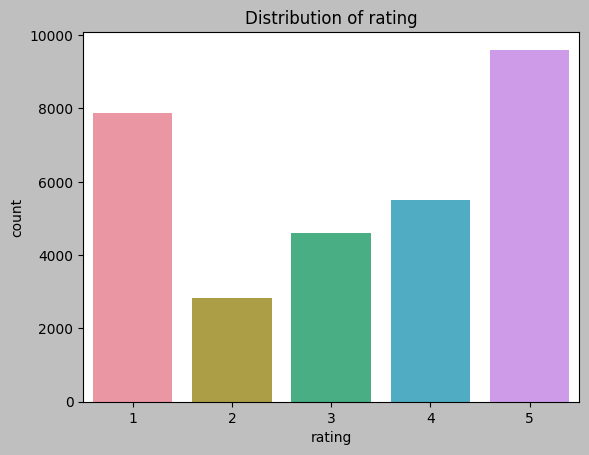

In [9]:
#plot rating distribution
sns.countplot(data=df, x='rating')
plt.title('Distribution of rating')
plt.show()

## RoBERTa Pretrained Model
RoBERTa is a transformers model pretrained on a large corpus of English data in a self-supervised fashion

Unlike ntlk model, which only accounts for the meaning of the word itself, this transformer models account for both the meaning of the word itself and the meaning of the word considering the context it is being used in, which is a very important part of human language. 

In [10]:
# define the model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

I will get an example review from the dataframe to test the RoBERTa model

In [11]:
# define an example to test the model
example = df['review'].loc[0]
example

'Why does it look like someone spit on my food?\nI had a normal transaction,  everyone was chill and polite, but now i dont want to eat this. Im trying not to think about what this milky white/clear substance is all over my food, i d*** sure am not coming back.'

In [12]:
# Run the RoBERTa model on the example 
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.96296793, 'roberta_neu': 0.033355907, 'roberta_pos': 0.0036761947}


The model seems very confident in its assesment of the review. 

Now, I will test the model with another sentence. I will construct a sentence with a positive tone, but could be misundertood as negative if not considering the context of the entire sentence carefully. This will test RoBERTa model on its ability to understand the context of the whole sentence. 

In [13]:
example = "She's never been more careless with her money, and it's really paying off for her."

The sentence is positive, emphasizing that her financial success is due to her unintentional carelessness with money, making it a potentially misunderstood negative statement.

In [14]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.06379991, 'roberta_neu': 0.31201988, 'roberta_pos': 0.62418026}


The roBERTa is now less confident in its assesment, but it still arrives with the correct intepretation. 

I will now run the RoBERTa model on the entire dataframe

Since the RoBERTa model's maximum sequence length is 512, I will have to remove reviews with lengh of above 512 characters from the dataframe.


In [15]:
# remove reviews with lengh of above 512 characters
df = df[df['review'].str.len() <= 512]
print('Total of rows remained:,', len(df))


Total of rows remained:, 29511


In [16]:
# create a function to calculate and return the results of roberta scores
def scores_roberta(review):
    encoded_text = tokenizer(review, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return list(scores)

In [17]:
# add the roberta scores to a new dataframe
reviewer_ids = []
scores = []
for index, row in df.iterrows():
    try:
        score = scores_roberta(row['review'])
        reviewer_ids.append(row['reviewer_id'])
        scores.append(score)
    except RuntimeError:
        print('Broke for id', row['reviewer_id'])

scores_dict = {'reviewer_id': reviewer_ids,
        'roberta_scores': scores    
}

scores_df = pd.DataFrame(scores_dict)

"\n# add the roberta scores to a new dataframe\nreviewer_ids = []\nscores = []\nfor index, row in df.iterrows():\n    try:\n        score = scores_roberta(row['review'])\n        reviewer_ids.append(row['reviewer_id'])\n        scores.append(score)\n    except RuntimeError:\n        print('Broke for id', row['reviewer_id'])\n\nscores_dict = {'reviewer_id': reviewer_ids,\n        'roberta_scores': scores    \n}\n\nscores_df = pd.DataFrame(scores_dict)\n"

In [18]:
# merge with the original dataframe
df = df.merge(scores_df, on='reviewer_id')
df.head()

"\n# merge with the original dataframe\ndf = df.merge(scores_df, on='reviewer_id')\ndf.head()\n"

In [21]:
# create 3 new columns negative, neutral, positive corresponding to the roberta scores
df['negative'] = df['roberta_scores'].apply(lambda x: x[0])
df['neutral'] = df['roberta_scores'].apply(lambda x: x[1])
df['positive'] = df['roberta_scores'].apply(lambda x: x[2])

I have now sucessfully added the roberta score of each review to the dataframe. 

In [22]:
df.head()

,reviewer_id,store_address,latitude,longitude,review,rating,city,state,roberta_scores,negative,neutral,positive
0,1,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,Why does it look like someone spit on my food?...,1,Austin,TX 78750,"[0.96296793, 0.033355907, 0.0036761947]",0.962968,0.033356,0.003676
1,2,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,It'd McDonalds. It is what it is as far as the...,4,Austin,TX 78750,"[0.0024196967, 0.021860076, 0.97572017]",0.002420,0.021860,0.975720
4,5,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"I repeat my order 3 times in the drive thru, a...",1,Austin,TX 78750,"[0.9295495, 0.064213105, 0.0062374272]",0.929550,0.064213,0.006237
5,6,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,I work for door dash and they locked us all ou...,1,Austin,TX 78750,"[0.90291417, 0.088998325, 0.008087566]",0.902914,0.088998,0.008088
7,9,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,Went thru drive thru. Ordered. Getting home no...,1,Austin,TX 78750,"[0.93729675, 0.057387885, 0.0053154747]",0.937297,0.057388,0.005315


Based on the RoBERTa scores, I classify the reviews into 3 types: Negative, Neutral, and Positive. This classification is based on which roberta element of the review has the highest value. 

I will add a new column called sentiment to the dataframe to store the type of the review. 

In [23]:
def classification(roberta_scores: list):
    if max(roberta_scores) == roberta_scores[0]:
        return 'Negative'
    if max(roberta_scores) == roberta_scores[1]:
        return 'Neutral'
    else:
        return 'Positive'

df['sentiment'] = df['roberta_scores'].apply(classification)

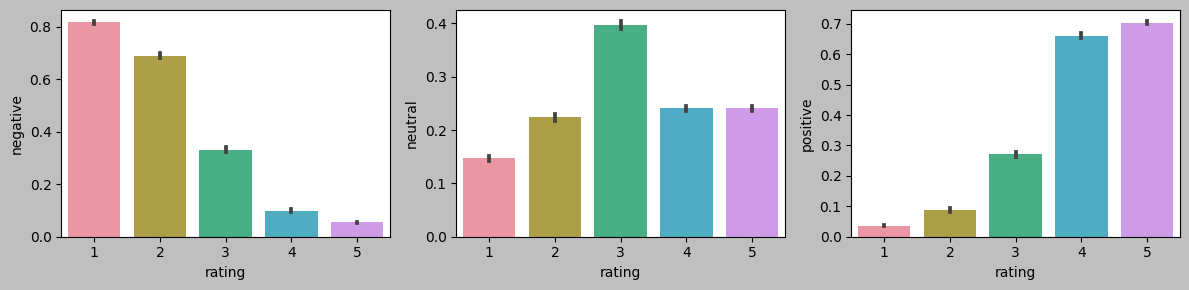

In [24]:
# plot roberta results
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df, x='rating', y='negative', ax=axs[0])
sns.barplot(data=df, x='rating', y='neutral', ax=axs[1])
sns.barplot(data=df, x='rating', y='positive', ax=axs[2])
plt.tight_layout()
plt.show()

## Modelling
In this section, i use Decision Tree Classifier and Support Vector Classifier (SVC) to build 2 models which predicts the sentiment of McDonald's reviews. I also compare the performance of the 2 models to determine the superior option

- **Decision Tree Classifier** is a supervised machine learning algorithm that makes predictions by partitioning the feature space into regions and assigning a class label to each region
- **SVC**, which belongs to the family of Support Vector Machines (SVM), is a supervised machine learning algorithm used for classification tasks. The primary goal of an SVC algorithm is to find a hyperplane that best separates data points into different classes

The course of action includes:
- data preprocessing
- intitating and training the models
- assessing the results
- finetuning

In [25]:
# The dataframe to be used for modelling
data = df[['reviewer_id', 'review', 'sentiment']]

print('The dataframe to be used for modelling:')
data.head(10)

The dataframe to be used for modelling:


,reviewer_id,review,sentiment
0,1,Why does it look like someone spit on my food?...,Negative
1,2,It'd McDonalds. It is what it is as far as the...,Positive
4,5,"I repeat my order 3 times in the drive thru, a...",Negative
5,6,I work for door dash and they locked us all ou...,Negative
7,9,Went thru drive thru. Ordered. Getting home no...,Negative
9,12,We stopped by for a quick breakfast. It was n...,Negative
10,13,The morning crew seems fast and efficient. Nig...,Negative
11,14,"Today, i was disappointed in that restaurant #...",Negative
12,15,Ordered food burger wrong and left out part of...,Negative
13,16,This was a dine in experience. The tables were...,Negative


Define the feature/label and split the dataset into training and test set

In [26]:
# Define feature and label
X = df['review']
y = df['sentiment']

# split the data into training and test set using train_test_split function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Text(0, 0.5, 'Set')

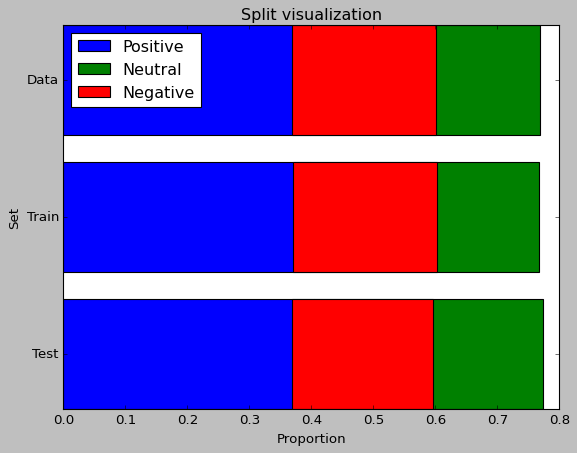

In [27]:
plt.style.use('classic')
train_dist = y_train.value_counts()/len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts()/len(y_test)
data_dist = y.value_counts()/len(y)

fig, ax = plt.subplots()
ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], label='Positive')
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], label='Neutral')
ax.barh(['Test','Train','Data'], [test_dist[2], train_dist[2], data_dist[2]], left=[test_dist[1], train_dist[1], data_dist[1]], label='Negative')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Set')

I use vectorization technique to convert textual data (reviews) into a numerical representation that the SVC model can work with. 

In [28]:
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Decision Tree Classifier

In [29]:
# Create a Decision Tree Classifier
clf_dtc = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=5)

# fit training data
clf_dtc.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [30]:
# Use classifier to predict labels
y_pred_dtc = clf_dtc.predict(X_test_tfidf)

# results
print('Accuracy is: ', (accuracy_score(y_test, y_pred_dtc)*100).round(2))
print()

# probabilities
y_pred_probs = clf_dtc.predict_proba(X_test_tfidf).round(2)
print(y_pred_probs)

class_labels_dtc = clf_dtc.classes_
print(class_labels_dtc)

Accuracy is:  66.05

[[0.04 0.02 0.94]
 [0.04 0.02 0.94]
 [0.53 0.18 0.29]
 ...
 [0.53 0.18 0.29]
 [0.53 0.18 0.29]
 [0.04 0.02 0.94]]
['Negative' 'Neutral' 'Positive']


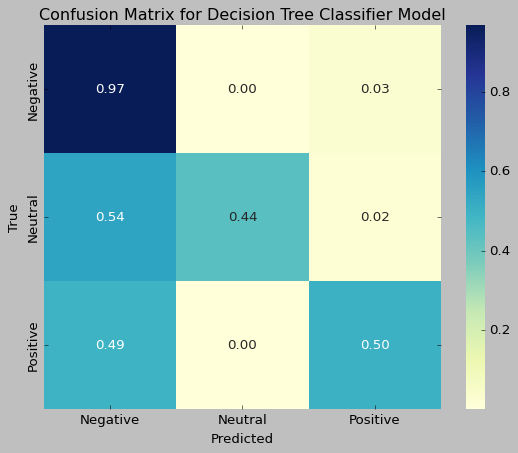

In [31]:
# confusion matrix
conf_matrix_dtc = confusion_matrix(y_test, y_pred_dtc, labels=class_labels_dtc)
# normalize the confusion matrix
cmn_dtc = conf_matrix_dtc.astype('float') / conf_matrix_dtc.sum(axis=1)[:, np.newaxis] 

# Create a heatmap
sns.heatmap(cmn_dtc, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=class_labels_dtc, yticklabels=class_labels_dtc)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Decision Tree Classifier Model')
plt.show()

### Support Vector Classifier

In [32]:
# Create a Support Vector Classifier
clf_svc = SVC()

# fit training data
clf_svc.fit(X_train_tfidf, y_train)

SVC()

In [33]:
# Use classifier to predict labels
y_pred_svc = clf_svc.predict(X_test_tfidf)

# results
print('Accuracy is: ', (accuracy_score(y_test, y_pred_svc)*100).round(2))
print()

# class labels
class_labels_svc = clf_svc.classes_
print(class_labels_svc)

Accuracy is:  88.63

['Negative' 'Neutral' 'Positive']


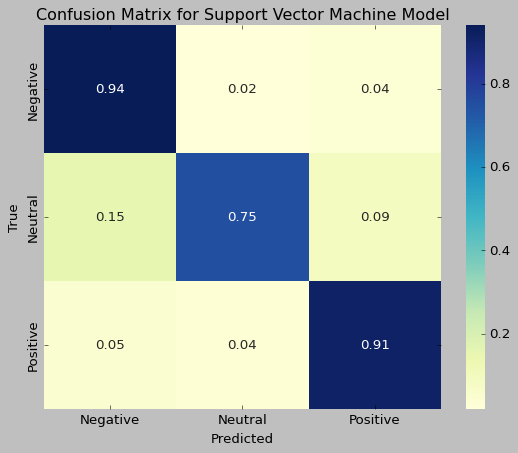

In [34]:
# confusion matrix
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc, labels=class_labels_svc)
# normalize
cmn_svc = conf_matrix_svc.astype('float') / conf_matrix_svc.sum(axis=1)[:, np.newaxis] 

# Create a heatmap
sns.heatmap(cmn_svc, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=class_labels_svc, yticklabels=class_labels_svc)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Support Vector Machine Model')
plt.show()

Looking at the accuracy scores and the confusion matrices, I conclude that the Support Vector Classifier model is significantly superior to the Decisiono Tree Classifier model. While both models can identify negative reviews equally well, the Support Vector Machine model performs a lot better with neutral and positive reviews.

Now, I will GridSearchCV to finetune the Support Vector Machine model.

Due to limited computing memory, I will only use 10% of the dataset. 

In [38]:
ft_df = df.sample(n=3000, random_state=1)
# Define feature and label
X = ft_df['review']
y = ft_df['sentiment']

# split the data into training and test set using train_test_split function
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X, y, test_size=0.2)

Text(0, 0.5, 'Set')

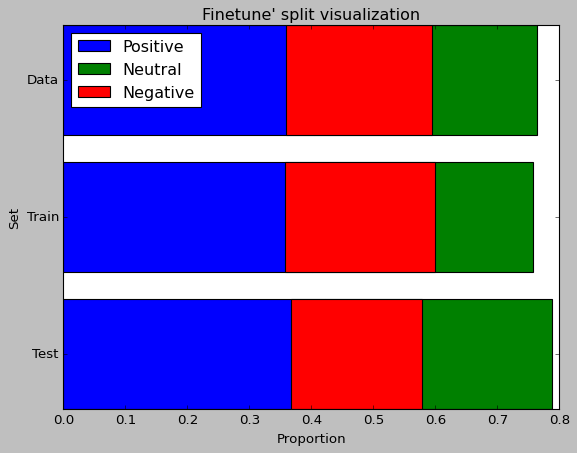

In [39]:
plt.style.use('classic')
train_dist = y_train_ft.value_counts()/len(y_train_ft) #normalize absolute count values for plotting
test_dist = y_test_ft.value_counts()/len(y_test_ft)
data_dist = y.value_counts()/len(y)

fig, ax = plt.subplots()
ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], label='Positive')
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], label='Neutral')
ax.barh(['Test','Train','Data'], [test_dist[2], train_dist[2], data_dist[2]], left=[test_dist[1], train_dist[1], data_dist[1]], label='Negative')
ax.set_title("Finetune' split visualization")
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Set')

In [40]:
# Vectorizing
X_train_ft_tfidf = vectorizer.fit_transform(X_train_ft)
X_test_ft_tfidf = vectorizer.transform(X_test_ft)

In [41]:
# finetune
svc = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_ft_tfidf, y_train_ft)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [42]:
# Get the best parameters 
best_params = grid_search.best_params_
best_params

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [43]:
# optimal SVC model
best_svc = grid_search.best_estimator_
best_svc

SVC(C=10)

In [44]:
# Evaluate the model on the test set#
y_pred_ft_svc = best_svc.predict(X_test_ft_tfidf)

# results
print('Accuracy is: ', (accuracy_score(y_test_ft, y_pred_ft_svc)*100).round(2))
print()

# class labels
print(best_svc.classes_)

Accuracy is:  84.67

['Negative' 'Neutral' 'Positive']


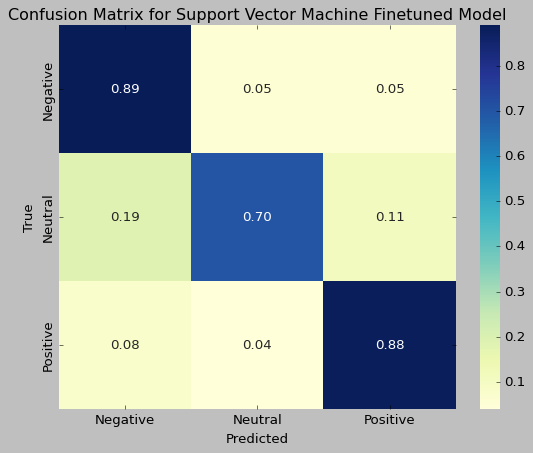

In [45]:
# confusion matrix
conf_matrix_ft_svc = confusion_matrix(y_test_ft, y_pred_ft_svc, labels=best_svc.classes_)
# normalize
cmn_ft_svc = conf_matrix_ft_svc.astype('float') / conf_matrix_ft_svc.sum(axis=1)[:, np.newaxis] 

# Create a heatmap
sns.heatmap(cmn_ft_svc, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=best_svc.classes_, yticklabels=best_svc.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Support Vector Machine Finetuned Model')
plt.show()